In [9]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize as NormColor
from tqdm.notebook import tqdm
sys.path.append(".")
import HOD as HOD
import HOD_spline as HOD_spline
from astropy.cosmology import Planck15
cosmo = Planck15 #FlatLambdaCDM(H0=67.74, Om0=0.3089, Tcmb0=2.725)
h = cosmo.H(0).value/100
LOW_RES = True

M_min, M_sat = 10**11.5, 10**12.5
sigma_logM, alpha = 0.2, 1.0
SHOW_HALO_TERMS = 1

def read_Nico_data(fname):
    data = pd.read_csv(fname, sep=' ')
    bin_centre = data['theta_bin'].to_numpy()
    w_obs = data['w_theta'].to_numpy()
    w_err = data['err_w_theta'].to_numpy()
    z_array = data['z_array'].to_numpy()
    Nz = data['Nz'].to_numpy()
    z_array, Nz = z_array[z_array>0], Nz[z_array>0]
    N_norm = Nz / (np.sum(Nz) * np.diff(z_array)[0])
    return bin_centre, w_obs, w_err, z_array, N_norm

fnames = ['ACF_new_parameters_z5.5.txt',
          'ACF_new_parameters_z6.5.txt',
          'ACF_new_parameters_z7.4.txt',
          'ACF_new_parameters_z8.5.txt',
          'ACF_new_parameters_z9.3.txt',
          'ACF_new_parameters_z10.6.txt',
          'ACF_new_parameters_z11.5.txt']

fname = fnames[0]
bin_centre, w_obs, w_err, z_array, N_norm = read_Nico_data('Data_Nico/'+fname)
t_Nico = bin_centre/206265
chi2_best, M_sat_best, M_min_best = np.infty, M_sat, M_min

In [10]:
# from scipy.interpolate import splrep, splev, splint
# from halomod.bias import Tinker10
# from scipy import special
# STEP_J0 = 100_000
# theta = 1/206265
# z = 5
# mag_min = -22.3
# mag_max = -15.5
# SPL_ORDER = 1
# M_DM_min, M_DM_max = HOD_spline.get_M_DM_range(np.mean(z_array), mag_max, mag_min, delta_z=0.5)
# c_light  = 299792.458 #speed of light km/s
# sigma_8 = 0.8159
# M_h_array, __, ___, ____, _____ = HOD_spline.init_lookup_table(0, False, False, LOW_RES, M_DM_min, M_DM_max)
# NCEN = HOD_spline.N_cen(M_h_array, M_min, sigma_logM)
# NSAT = HOD_spline.N_sat(M_h_array, M_sat, alpha, M_min, sigma_logM)
# M_h_array, HMF_array, nu_array, k_array, hmf_PS = \
#             HOD_spline.init_lookup_table(z, False, False, LOW_RES, M_DM_min, M_DM_max)
# crit_dens_rescaled = (4/3*np.pi*cosmo.critical_density(z).value*200*2e40)
# U_FT = np.array([HOD_spline.u_FT(k, M_h_array, z, crit_dens_rescaled) for k in k_array])
# bias = Tinker10(nu=nu_array, sigma_8 = sigma_8, cosmo = cosmo).bias()
# comoving_distance_z = cosmo.comoving_distance(z).value
# PS_1 = HOD_spline.PS_1h(M_h_array, HMF_array, NCEN, NSAT, U_FT, bias)
# N1   = np.max(PS_1)
# PS_1 = PS_1 / N1
# R_T1 = 0
# PS_1_spl   = splrep(k_array, PS_1  , s=0, k=SPL_ORDER)
# j_0_zeros = special.jn_zeros(0, STEP_J0+1)
# t = theta
# k0 = j_0_zeros[0]/t/comoving_distance_z
# k_here = np.append(k_array[k_array<k0], k0)
# PS_1_here = splev(k_here, PS_1_spl)
# Bessel = np.array([special.j0(k*t*comoving_distance_z) for k in k_here])
# integrand = PS_1_here * k_here / (2*np.pi) * Bessel
# A_sp = splrep(k_here, integrand, s=0, k=SPL_ORDER)
# R_T1 += splint(k_here[0], k_here[-1], A_sp)

# fig, ax = plt.subplots(2, 2, figsize=(12, 7), sharex=False)
# _c = 'k'
# ax[0, 1].plot(k_here, PS_1_here, color = _c)
# ax[1, 0].plot(k_here, Bessel, color = _c)
# ax[1, 1].plot(k_here, integrand, color = _c)
# i, DELTA_J0, RES_J0 = 0, 1_000, 8
# col = iter(cm.prism(np.linspace(0, 1, STEP_J0//DELTA_J0)))
# while i <= STEP_J0 - DELTA_J0:
#     j_array = np.linspace(j_0_zeros[i], j_0_zeros[i+DELTA_J0], DELTA_J0*RES_J0)
#     k_here = j_array / t / comoving_distance_z
#     PS_1_here = splev(k_here, PS_1_spl)
#     Bessel = np.array([special.j0(k*t*comoving_distance_z) for k in k_here])
#     integrand = PS_1_here * k_here / (2*np.pi) * Bessel
#     _c = next(col)
#     ax[0, 1].plot(k_here, PS_1_here, color = _c)
#     ax[1, 0].plot(k_here, Bessel, color = _c)
#     ax[1, 1].plot(k_here, integrand, color = _c)
#     A_sp = splrep(k_here, integrand, s=0, k=SPL_ORDER)
#     R_T1 += splint(k_here[0], k_here[-1], A_sp)
#     i += DELTA_J0
# print('1h: ', R_T1*N1)
# SYMLOGT = 1e-9
# ax[0, 0].set_xscale('log')
# ax[0, 0].set_yscale('symlog', linthresh=SYMLOGT)
# ax[0, 0].set_xlabel(r'$k$ [1/Mpc]')
# ax[0, 0].set_ylabel('hmf_PS')
# ax[0, 1].set_xscale('log')
# ax[0, 1].set_yscale('symlog', linthresh=SYMLOGT)
# ax[0, 1].set_xlabel(r'$k$ [1/Mpc]')
# ax[0, 1].set_ylabel('PS_1')
# ax[1, 0].set_xscale('log')
# ax[1, 0].set_yscale('symlog', linthresh=SYMLOGT)
# ax[1, 0].set_xlabel(r'$k$ [1/Mpc]')
# ax[1, 0].set_ylabel('Bessel')
# ax[1, 1].set_xscale('log')
# ax[1, 1].set_yscale('symlog', linthresh=SYMLOGT)
# ax[1, 1].set_xlabel(r'$k$ [1/Mpc]')
# ax[1, 1].set_ylabel('integrand')

# ax[0, 0].set_ylim((-1, 1e4))
# ax[0, 1].set_ylim((-1, 1e4))
# ax[1, 0].set_ylim((-1, 1e4))
# ax[1, 1].set_ylim((-1, 1e4))
# plt.legend()
# plt.show()

# PS_1 = HOD_spline.PS_2h(M_h_array, HMF_array, NCEN, NSAT, U_FT, bias)
# N1   = np.max(PS_1)
# PS_1 = PS_1 / N1
# R_T1 = 0
# hmf_PS_spl = splrep(k_array, hmf_PS, s=0, k=SPL_ORDER)
# PS_1_spl   = splrep(k_array, PS_1  , s=0, k=SPL_ORDER)
# j_0_zeros = special.jn_zeros(0, STEP_J0+1)
# t = theta
# k0 = j_0_zeros[0]/t/comoving_distance_z
# k_here = np.append(k_array[k_array<k0], k0)
# hmf_PS_here = splev(k_here, hmf_PS_spl)
# PS_1_here = splev(k_here, PS_1_spl)
# Bessel = np.array([special.j0(k*t*comoving_distance_z) for k in k_here])
# integrand = hmf_PS_here * PS_1_here * k_here / (2*np.pi) * Bessel
# A_sp = splrep(k_here, integrand, s=0, k=SPL_ORDER)
# R_T1 += splint(k_here[0], k_here[-1], A_sp)

# fig, ax = plt.subplots(2, 2, figsize=(12, 7), sharex=False)
# _c = 'k'
# ax[0, 0].plot(k_here, hmf_PS_here, color = _c)
# ax[0, 1].plot(k_here, PS_1_here, color = _c)
# ax[1, 0].plot(k_here, Bessel, color = _c)
# ax[1, 1].plot(k_here, integrand, color = _c)
# i, DELTA_J0, RES_J0 = 0, 1_000, 8
# col = iter(cm.prism(np.linspace(0, 1, STEP_J0//DELTA_J0)))
# while i <= STEP_J0 - DELTA_J0:
#     j_array = np.linspace(j_0_zeros[i], j_0_zeros[i+DELTA_J0], DELTA_J0*RES_J0)
#     k_here = j_array / t / comoving_distance_z
#     hmf_PS_here = splev(k_here, hmf_PS_spl)
#     PS_1_here = splev(k_here, PS_1_spl)
#     Bessel = np.array([special.j0(k*t*comoving_distance_z) for k in k_here])
#     integrand = hmf_PS_here * PS_1_here * k_here / (2*np.pi) * Bessel
#     _c = next(col)
#     ax[0, 0].plot(k_here, hmf_PS_here, color = _c)
#     ax[0, 1].plot(k_here, PS_1_here, color = _c)
#     ax[1, 0].plot(k_here, Bessel, color = _c)
#     ax[1, 1].plot(k_here, integrand, color = _c)
#     A_sp = splrep(k_here, integrand, s=0, k=SPL_ORDER)
#     R_T1 += splint(k_here[0], k_here[-1], A_sp)
#     i += DELTA_J0
# print('2h: ', R_T1*N1)
# SYMLOGT = 1e-9
# ax[0, 0].set_xscale('log')
# ax[0, 0].set_yscale('symlog', linthresh=SYMLOGT)
# ax[0, 0].set_xlabel(r'$k$ [1/Mpc]')
# ax[0, 0].set_ylabel('hmf_PS')
# ax[0, 1].set_xscale('log')
# ax[0, 1].set_yscale('symlog', linthresh=SYMLOGT)
# ax[0, 1].set_xlabel(r'$k$ [1/Mpc]')
# ax[0, 1].set_ylabel('PS_2')
# ax[1, 0].set_xscale('log')
# ax[1, 0].set_yscale('symlog', linthresh=SYMLOGT)
# ax[1, 0].set_xlabel(r'$k$ [1/Mpc]')
# ax[1, 0].set_ylabel('Bessel')
# ax[1, 1].set_xscale('log')
# ax[1, 1].set_yscale('symlog', linthresh=SYMLOGT)
# ax[1, 1].set_xlabel(r'$k$ [1/Mpc]')
# ax[1, 1].set_ylabel('integrand')

# ax[0, 0].set_ylim((-1, 1e4))
# ax[0, 1].set_ylim((-1, 1e4))
# ax[1, 0].set_ylim((-1, 1e4))
# ax[1, 1].set_ylim((-1, 1e4))
# plt.legend()
# plt.show()


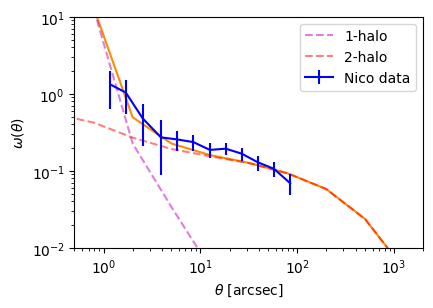

CPU times: user 17.9 s, sys: 141 ms, total: 18 s
Wall time: 18 s


In [11]:
%%time
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), sharex=False, sharey=False)
th_arr = np.logspace(-0.5, 3.5, 11)/206265
o1_N_spl = HOD_spline.omega_1halo_singleCore(th_arr, M_min_best, sigma_logM, M_sat_best, alpha, N_norm, z_array, LOW_RES=LOW_RES, mag_min = -22.3, mag_max = -15.5)
o2_N_spl = HOD_spline.omega_2halo_singleCore(th_arr, M_min_best, sigma_logM, M_sat_best, alpha, N_norm, z_array, LOW_RES=LOW_RES, mag_min = -22.3, mag_max = -15.5)
ax.plot(th_arr*206265, o1_N_spl+o2_N_spl, c = 'darkorange', ls = '-')
ax.plot(th_arr*206265, o1_N_spl, c = 'm', ls = '--', alpha = 0.5, label='1-halo')
ax.plot(th_arr*206265, o2_N_spl, c = 'r', ls = '--', alpha = 0.5, label='2-halo')
ax.errorbar(bin_centre,w_obs, w_err, c='b', label='Nico data')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((0.5,2e3))
ax.set_ylim((1e-2, 1e1))
ax.set_xlabel(r'$\theta$ [arcsec]')
ax.set_ylabel(r'$\omega$($\theta$)')
plt.legend()
plt.show()

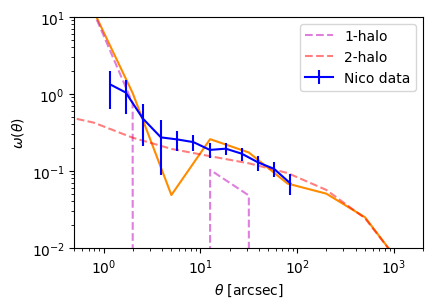

CPU times: user 4.2 s, sys: 134 ms, total: 4.33 s
Wall time: 3.94 s


In [12]:
%%time
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), sharex=False, sharey=False)
th_arr = np.logspace(-0.5, 3.5, 11)/206265
o1_N = HOD.omega_1halo_singleCore(th_arr, M_min_best, sigma_logM, M_sat_best, alpha, N_norm, z_array, LOW_RES=LOW_RES, mag_min = -22.3, mag_max = -15.5)
o2_N = HOD.omega_2halo_singleCore(th_arr, M_min_best, sigma_logM, M_sat_best, alpha, N_norm, z_array, LOW_RES=LOW_RES, mag_min = -22.3, mag_max = -15.5)
ax.plot(th_arr*206265, o1_N+o2_N, c = 'darkorange', ls = '-')
ax.plot(th_arr*206265, o1_N, c = 'm', ls = '--', alpha = 0.5, label='1-halo')
ax.plot(th_arr*206265, o2_N, c = 'r', ls = '--', alpha = 0.5, label='2-halo')
ax.errorbar(bin_centre,w_obs, w_err, c='b', label='Nico data')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((0.5,2e3))
ax.set_ylim((1e-2, 1e1))
ax.set_xlabel(r'$\theta$ [arcsec]')
ax.set_ylabel(r'$\omega$($\theta$)')
plt.legend()
plt.show()